# Thymus human spatial atlas
# Multi resolution annotation from high resolution annotation  
# last edit 310723

In [1]:
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())

import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

In [ ]:
%cd /nfs/team205/vk8/projects/thymus_atlas/ThymusSpatialAtlas

/nfs/team205/ny1/ThymusSpatialAtlas


In [3]:
results = ''

## Load full thymus dataset

In [4]:
h5ad_file = '/Thymus_Atlas_v13_w_past.h5ad'

adata_full = sc.read_h5ad(h5ad_file)
# adata_full.write_h5ad(h5ad_file)

## Load individual datasets

In [5]:
objects = ['Blood_cells_spatlas_scvi_dbrm_2023-07-31.h5ad', 'Bcells_spatlas_scvi_dbrm_2023-07-29.h5ad',
          'Myeloid_spatlas_scvi_dbrm_2023-07-28.h5ad', 'TEC_spatlas_scvi_dbrm_2023-07-19.h5ad', 'Endo_spatlas_scvi_2023-07-18.h5ad',
          'SMC_spatlas_scvi_dbrm_2023-07-17.h5ad', 'FB_spatlas_scvi_dbrm_2023-06-28.h5ad', 'Schwann_cells_spatlas_2023-07-31.h5ad']

In [6]:
combined_obs = pd.DataFrame()
for adata in objects:
    adata_input = sc.read(f'{results}{adata}')
    if 'annotation_level_3_new' in adata_input.obs.columns:
        print(f"{adata}, cell anno changed")
        combined_obs = pd.concat([combined_obs, adata_input.obs[['annotation_level_3', 'annotation_level_3_new']]])
    else:
        print(f"{adata}, cell anno kept the same")
        combined_obs = pd.concat([combined_obs, adata_input.obs[['annotation_level_3']]])

Blood_cells_spatlas_scvi_dbrm_2023-07-31.h5ad, cell anno changed
Bcells_spatlas_scvi_dbrm_2023-07-29.h5ad, cell anno changed
Myeloid_spatlas_scvi_dbrm_2023-07-28.h5ad, cell anno changed
TEC_spatlas_scvi_dbrm_2023-07-19.h5ad, cell anno kept the same
Endo_spatlas_scvi_2023-07-18.h5ad, cell anno changed
SMC_spatlas_scvi_dbrm_2023-07-17.h5ad, cell anno kept the same
FB_spatlas_scvi_dbrm_2023-06-28.h5ad, cell anno changed
Schwann_cells_spatlas_2023-07-31.h5ad, cell anno kept the same


## Load Nadav's annotation

In [ ]:
dn_obs_ped = pd.read_csv('/htsa_DN_paed_anno_310723.csv',index_col = 0)
dn_obs_fet = pd.read_csv('/htsa_DN_fetal_anno_310723.csv',index_col = 0)
dp_obs = pd.read_csv('/htsa_DP_anno_310723.csv', index_col = 0)
sp_obs = pd.read_csv('/htsa_SP_anno_310723.csv', index_col = 0)
Treg_obs = pd.read_csv('/htsa_Treg_anno_310723.csv', index_col = 0)

/tmp/ipykernel_4530/3950186459.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  dp_obs = pd.read_csv('/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/annotation_done/htsa_DP_anno_310723.csv', index_col = 0)
/tmp/ipykernel_4530/3950186459.py:4: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  sp_obs = pd.read_csv('/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/annotation_done/htsa_SP_anno_310723.csv', index_col = 0)


In [9]:
dn_obs_ped.columns[0]

'cell_type_level_3'

In [10]:

for dt in [dn_obs_ped, dn_obs_fet, dp_obs, Treg_obs, sp_obs]:
    dt.rename(columns = {'cell_type_level_3':'annotation_level_3_new'}, inplace = True)
    combined_obs = pd.concat([combined_obs, dt[['annotation_level_3', 'annotation_level_3_new']]])
combined_obs = combined_obs[~combined_obs.index.duplicated(keep='first')]

In [11]:
adata_prev = sc.read('/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/annotation_done/HTSA_v17.h5ad')

### These are the cells that missing atm... Mural and VSMC are doublets

In [12]:
combined_obs = pd.concat([combined_obs, adata_prev.obs.loc[adata_prev.obs['annotation_level_3'].isin(['Mast', 'Mesothelium']), ['annotation_level_3']]])

In [13]:
set(adata_prev.obs['annotation_level_3']).difference(set(combined_obs['annotation_level_3']))

{'Mural', 'VSMC', 'VSMC_like'}

In [14]:
combined_obs['cell_type_level_4'] = combined_obs['annotation_level_3_new'].copy()

combined_obs.loc[pd.isna(combined_obs["annotation_level_3_new"]), 'cell_type_level_4'] = combined_obs.loc[pd.isna(combined_obs["annotation_level_3_new"]), 'annotation_level_3'].copy()

In [15]:
[i for i in combined_obs.index if i not in adata_full.obs_names]

[]

In [16]:
len([i for i in adata_full.obs_names if i not in combined_obs.index])

157694

In [17]:
adata_full.obs['cell_type_level_4'] = combined_obs.reindex(adata_full.obs_names)['cell_type_level_4']

In [18]:
adata_full.obs.loc[pd.isnull(adata_full.obs['cell_type_level_4']), 'cell_type_level_4'] = 'FailQC'

In [23]:
# obs['validated_doublet'].astype('category')
# obs['annotation_level_4'].astype('category')
# adata_full.obs = obs
sc.set_figure_params(figsize=[15,15],fontsize=20)
# sc.pl.umap(adata_full, color=['annotation_level_1'],groups='blood', legend_loc='on data',s=2)
# sc.set_figure_params(figsize=[10,10])
sc.pl.umap(adata_full, color=['cell_type_level_4'], legend_loc='on data',legend_fontsize = 10)

In [26]:
granular_ctype_dict = {}
for i in adata_full.obs['cell_type_level_4'].cat.categories:
    granular_ctype_dict[i] = {i}
    

In [27]:
granular_ctype_dict

{'B-Prolif': {'B-Prolif'},
 'B-memory': {'B-memory'},
 'B-naive': {'B-naive'},
 'B-plasma': {'B-plasma'},
 'B_pro_pre': {'B_pro_pre'},
 'CMP': {'CMP'},
 'DC1': {'DC1'},
 'DC1-Prolif': {'DC1-Prolif'},
 'DC2': {'DC2'},
 'DC2-Prolif': {'DC2-Prolif'},
 'EC-Art': {'EC-Art'},
 'EC-Art-ELN': {'EC-Art-ELN'},
 'EC-Cap': {'EC-Cap'},
 'EC-Cap-Prolif': {'EC-Cap-Prolif'},
 'EC-Lymphatic': {'EC-Lymphatic'},
 'EC-Ven': {'EC-Ven'},
 'EC-Ven-ELN': {'EC-Ven-ELN'},
 'FailQC': {'FailQC'},
 'GMP': {'GMP'},
 'InterloFb': {'InterloFb'},
 'InterloFb-COL9A3': {'InterloFb-COL9A3'},
 'Macrophage-APOC2': {'Macrophage-APOC2'},
 'Macrophage-LYVE1': {'Macrophage-LYVE1'},
 'Macrophage-SPIC1': {'Macrophage-SPIC1'},
 'Mast': {'Mast'},
 'Mesothelium': {'Mesothelium'},
 'Monocyte_CCR2': {'Monocyte_CCR2'},
 'Monocyte_IL1B': {'Monocyte_IL1B'},
 'Myelocyte': {'Myelocyte'},
 'Neutrophil': {'Neutrophil'},
 'Pericyte': {'Pericyte'},
 'Pericyte_CCL19': {'Pericyte_CCL19'},
 'Pericyte_COL1A1': {'Pericyte_COL1A1'},
 'PeriloFb': {'

In [ ]:
prolif_cells = ['DC1-Prolif', 'DC2-Prolif', 'PeriloFb-Prolif', 'ProlifPericyte', 'pDC-Prolif', 'mcTEC-Prolif']

## multilevel annotations



In [51]:
# lv 3 (level for fine spatial mapping)
dict_anno_v3 = {
             'FailQC':{'FailQC'},
                
    
             'T_CD4': {'T_CD4','T_cycling'},
             'T_CD8': {'T_CD8','T_CD8-Prolif','T_CD8_memory'},
             'T_CD8αα': {'T_CD8αα(I)','T_CD8αα(II)','T_CD8αα(entry)'},
             'T_DN(P)': {'T_DN(P)'},
             'T_DN(Q)': {'T_DN(Q)','T_DN(Q)-CD99','T_DN(Q)-HSPH1','T_DN(Q)-early'},
             'T_DN(early)': {'T_DN(early)','T_ISP'},
             'T_DP(P)': {'T_DP(P)'},
             'T_DP(Q)': {'T_DP(Q)','T_DP(Q)-CD99','T_DP(Q)-HSPH1','T_DP(Q)-early','T_DP(Q)-late_vdj'},
             'T_NK': {'T_NK_dev','T_NK','T_NK_fetal'},
             'T_SP_general' : {'T_SP8or4','T_SP-HSP'},
             'T_Treg': {'T_Treg_CD8','T_Treg_mature','T_Treg_recirc','T_reg'},
             'T_innate': {'T_innate_type_1','T_innate_type_3'},
             'T_reg(diff)': {'T_reg(diff)-FOXP3Lo','T_reg(agonist)','T_reg(diff)-FOXP3hi'},
             'T_αβT(entry)': {'T_αβT(entry)','T_abT(entry)'},
             'T_γδT': {'T_γδT'},
             
             'pre_proB': {'pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B','B_pro_pre'},
             'B':{'B-naive', 'B-memory', 'B-Prolif'},
             'B-plasma': {'B-plasma'},
             'Progenitors':{'CMP','GMP'},
             'Mono':{'Promonocyte', 'Monocyte_CCR2', 'Monocyte_IL1B'},
             'Neut':{'Myelocyte','Neutrophil'},
             'Mast': {'Mast'},
             'RBC':{'RBC'},
             'DC1': {'DC1', 'DC1-Prolif'},
             'DC2': {'DC2', 'DC2-Prolif'},
             'pDC': {'pDC', 'pDC-Prolif'},
             'aDC1': {'aDC1'},
             'aDC2': {'aDC2'},
             'aDC3': {'aDC3'},
             'Macrophage-APOC2':{'Macrophage-APOC2'},
             'Macrophage-LYVE1':{'Macrophage-LYVE1'}, 
             'Macrophage-SPIC1':{'Macrophage-SPIC1'},
             'cTECI': {'cTECI'},
             'cTECII': {'cTECII'},
             'cTECIII': {'cTECIII'},
             'mTECI': {'mTECI'},
             'mTECI-trans': {'mTECI-trans'},
             'mTECII': {'mTECII'},
             'mTECIII': {'mTECIII'},
             'mcTEC': {'mcTEC','mcTEC-Prolif'},
             'TEC-cilliated': {'TEC-cilliated'},
             'TEC-myo': {'TEC-myo'},
             'TEC-neuro': {'TEC-neuro'},
             'TEC-tuft': {'TEC-tuft'},
            'EC-Art': {'EC-Art', 'EC-Art-ELN'},
            'EC-Cap':{'EC-Cap', 'EC-Cap-Prolif'},
            'EC-Ven':{'EC-Ven', 'EC-Ven-ELN'},
            'EC-Lymph':{'EC-Lymphatic'},
            'SMC':{'SMC'},
            'Pericyte': {'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte'},
            'PeriloFb': {'PeriloFb','PeriloFb-Prolif'},
            'InterloFb': {'InterloFb', 'InterloFb-COL9A3'},
            'medFB-MHCIIh': {'medFB-MHCIIh'},
            'medFb': {'medFb', 'medFb-RGS5'},
            'fetFB-CCL21': {'fetFB-CCL21'},
             'fetFB-NKX2-5': {'fetFB-NKX2-5'},
             'fetFB-RSPO2': {'fetFB-RSPO2'},
            'Mesothelium':{'Mesothelium'},
            'Schwann': {'Schwann'},
            'nmSchwann': {'nmSchwann'}
            }

adata_full.obs['cell_type_level_3'] = 'unassigned'
for key, values in dict_anno_v3.items():
    adata_full.obs.loc[adata_full.obs['cell_type_level_4'].isin(values), 'cell_type_level_3'] = key
adata_full.obs['cell_type_level_3'] = adata_full.obs['cell_type_level_3'].astype('category')    


In [52]:
adata_full.obs['cell_type_level_3'].cat.categories

Index(['B', 'B-plasma', 'DC1', 'DC2', 'EC-Art', 'EC-Cap', 'EC-Lymph', 'EC-Ven',
       'FailQC', 'InterloFb', 'Macrophage-APOC2', 'Macrophage-LYVE1',
       'Macrophage-SPIC1', 'Mast', 'Mesothelium', 'Mono', 'Neut', 'Pericyte',
       'PeriloFb', 'Progenitors', 'RBC', 'SMC', 'Schwann', 'TEC-cilliated',
       'TEC-myo', 'TEC-neuro', 'TEC-tuft', 'T_CD4', 'T_CD8', 'T_CD8αα',
       'T_DN(P)', 'T_DN(Q)', 'T_DN(early)', 'T_DP(P)', 'T_DP(Q)', 'T_NK',
       'T_SP_general', 'T_Treg', 'T_innate', 'T_reg(diff)', 'T_αβT(entry)',
       'T_γδT', 'aDC1', 'aDC2', 'aDC3', 'cTECI', 'cTECII', 'cTECIII',
       'fetFB-CCL21', 'fetFB-NKX2-5', 'fetFB-RSPO2', 'mTECI', 'mTECI-trans',
       'mTECII', 'mTECIII', 'mcTEC', 'medFB-MHCIIh', 'medFb', 'nmSchwann',
       'pDC', 'pre_proB'],
      dtype='object')

In [53]:
# lv 2 (level for coarse spatial mapping)
dict_anno_v2 = {
             'FailQC':{'FailQC'},

              
             'T_CD4': {'T_CD4','T_cycling'},
             'T_CD8': {'T_CD8','T_CD8-Prolif','T_CD8_memory'},
             'T_CD8αα': {'T_CD8αα(I)','T_CD8αα(II)','T_CD8αα(entry)'},
             'T_DN': {'T_DN(P)','T_DN(Q)','T_DN(Q)-CD99','T_DN(Q)-HSPH1','T_DN(Q)-early'},
             'T_DN(early)': {'T_DN(early)','T_ISP'},
             'T_DP': {'T_DP(Q)','T_DP(Q)-CD99','T_DP(Q)-HSPH1','T_DP(Q)-early','T_DP(Q)-late_vdj','T_DP(P)'},
             'T_NK': {'T_NK_dev','T_NK','T_NK_fetal'},
             'T_SP_general' : {'T_SP8or4','T_SP-HSP'},
             'T_Treg': {'T_Treg_CD8','T_Treg_mature','T_Treg_recirc','T_reg','T_reg(diff)-FOXP3Lo','T_reg(agonist)','T_reg(diff)-FOXP3hi'},
             'T_innate': {'T_innate_type_1','T_innate_type_3'},
             'T_αβT(entry)': {'T_αβT(entry)','T_abT(entry)'},
             'T_γδT': {'T_γδT'},
    
             'pre_proB': {'pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B','B_pro_pre'},
             'B':{'B-naive', 'B-memory', 'B-Prolif'},
             'B-plasma': {'B-plasma'},
             'Progenitors':{'CMP','GMP'},
             'Mono':{'Promonocyte', 'Monocyte_CCR2', 'Monocyte_IL1B'},
             'Neut':{'Myelocyte','Neutrophil'},
             'Mast': {'Mast'},
             'RBC':{'RBC'},
             'DC': {'DC1', 'DC1-Prolif', 'DC2', 'DC2-Prolif'},
             'pDC': {'pDC', 'pDC-Prolif'},
             'aDC': {'aDC1','aDC2','aDC3'},
             'Macro':{'Macrophage-APOC2', 'Macrophage-LYVE1','Macrophage-SPIC1'},
             'cTEC': {'cTECI', 'cTECII', 'cTECIII'},
             'mTEC': {'mTECI', 'mTECI-trans'},
             'mTEC-mimetic': {'mTECII', 'mTECIII', 'TEC-cilliated', 'TEC-myo', 'TEC-neuro',
                             'TEC-tuft'},
             'mcTEC': {'mcTEC','mcTEC-Prolif'},
            'EC-Art': {'EC-Art', 'EC-Art-ELN'},
            'EC-Cap':{'EC-Cap', 'EC-Cap-Prolif'},
            'EC-Ven':{'EC-Ven', 'EC-Ven-ELN'},
            'EC-Lymph':{'EC-Lymphatic'},
            'SMC':{'SMC'},
            'Pericyte': {'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte'},
            'PeriloFb': {'PeriloFb','PeriloFb-Prolif'},
            'InterloFb': {'InterloFb', 'InterloFb-COL9A3'},
            'medFb': {'medFb', 'medFb-RGS5', 'medFB-MHCIIh'},
            'fetFB-CCL21': {'fetFB-CCL21'},
             'fetFB-NKX2-5': {'fetFB-NKX2-5'},
             'fetFB-RSPO2': {'fetFB-RSPO2'},
            'Mesothelium':{'Mesothelium'},
            'Schwann': {'Schwann'},
            'nmSchwann': {'nmSchwann'}
            }

adata_full.obs['cell_type_level_2'] = 'unassigned'
adata_full.obs['cell_type_level_2'] = adata_full.obs['cell_type_level_2'].astype('object')
for key, values in dict_anno_v2.items():
    adata_full.obs.loc[adata_full.obs['cell_type_level_4'].isin(values), 'cell_type_level_2'] = key
adata_full.obs['cell_type_level_2'] = adata_full.obs['cell_type_level_2'].astype('category')   

In [54]:
# lv 1 (level for fine spatial mapping)
dict_anno_v1 = {
             'FailQC':{'FailQC'},
         
             'T_SP': {'T_CD4','T_cycling','T_CD8','T_CD8-Prolif','T_CD8_memory','T_αβT(entry)','T_abT(entry)'},
             'T_special': {'T_CD8αα(I)','T_CD8αα(II)','T_CD8αα(entry)','T_innate_type_1','T_innate_type_3','T_γδT'},
             'T_DN': {'T_DN(P)','T_DN(Q)','T_DN(Q)-CD99','T_DN(Q)-HSPH1','T_DN(Q)-early','T_DN(early)','T_ISP'},
             'T_DP': {'T_DP(Q)','T_DP(Q)-CD99','T_DP(Q)-HSPH1','T_DP(Q)-early','T_DP(Q)-late_vdj','T_DP(P)'},
             'T_NK': {'T_NK_dev','T_NK','T_NK_fetal'},
             'T_SP_general' : {'T_SP8or4','T_SP-HSP'},
             'T_Treg': {'T_Treg_CD8','T_Treg_mature','T_Treg_recirc','T_reg','T_reg(diff)-FOXP3Lo','T_reg(agonist)','T_reg(diff)-FOXP3hi'},
         
    
             'B':{'B-naive', 'B-memory', 'B-Prolif', 'B-plasma', 'pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B','B_pro_pre'},
             'Progenitors':{'CMP','GMP'},
             'Myeloid':{'Promonocyte', 'Monocyte_CCR2', 'Monocyte_IL1B', 'Myelocyte','Neutrophil', 'Mast', 'RBC'},
             'DC': {'DC1', 'DC1-Prolif', 'DC2', 'DC2-Prolif', 'pDC', 'pDC-Prolif', 'aDC1','aDC2','aDC3'},
             'Macro':{'Macrophage-APOC2', 'Macrophage-LYVE1','Macrophage-SPIC1'},
             'cTEC': {'cTECI', 'cTECII', 'cTECIII'},
             'mTEC': {'mTECI', 'mTECI-trans', 'mTECII', 'mTECIII', 'mcTEC','mcTEC-Prolif', 'TEC-cilliated',
                       'TEC-myo','TEC-neuro', 'TEC-tuft'},
            'EC': {'EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif','EC-Ven',
                       'EC-Ven-ELN'},
            'Lymph':{'EC-Lymphatic'},
            'SMC':{'SMC'},
            'Pericyte': {'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte'},
            'Fb': {'PeriloFb','PeriloFb-Prolif', 'InterloFb', 'InterloFb-COL9A3'},
            'medFb': {'medFb', 'medFb-RGS5', 'medFB-MHCIIh'},
            'fetFB': {'fetFB-CCL21', 'fetFB-NKX2-5', 'fetFB-RSPO2'},
            'Mesothelium':{'Mesothelium'},
            'Schwann': {'Schwann','nmSchwann'}
            }

adata_full.obs['cell_type_level_1'] = 'unassigned'
adata_full.obs['cell_type_level_1'] = adata_full.obs['cell_type_level_1'].astype('object')
for key, values in dict_anno_v1.items():
    adata_full.obs.loc[adata_full.obs['cell_type_level_4'].isin(values), 'cell_type_level_1'] = key
adata_full.obs['cell_type_level_1'] = adata_full.obs['cell_type_level_1'].astype('category')   

In [55]:
# lv 1 (level for fine spatial mapping)
dict_anno_v0 = {
        'FailQC':{'FailQC'},
        'T': {'T_CD4','T_cycling','T_CD8','T_CD8-Prolif','T_CD8_memory','T_αβT(entry)','T_abT(entry)',
                'T_Treg_CD8','T_Treg_mature','T_Treg_recirc','T_reg','T_reg(diff)-FOXP3Lo','T_reg(agonist)','T_reg(diff)-FOXP3hi',
                'T_CD8αα(I)','T_CD8αα(II)','T_CD8αα(entry)','T_innate_type_1','T_innate_type_3','T_γδT','T_SP8or4','T_SP-HSP',
                'T_DN(P)','T_DN(Q)','T_DN(Q)-CD99','T_DN(Q)-HSPH1','T_DN(Q)-early','T_DN(early)','T_ISP','T_NK_dev','T_NK','T_NK_fetal',
                'T_DP(Q)','T_DP(Q)-CD99','T_DP(Q)-HSPH1','T_DP(Q)-early','T_DP(Q)-late_vdj','T_DP(P)'},
    
        'B':{'B-naive', 'B-memory', 'B-Prolif', 'B-plasma', 'pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B','B_pro_pre'},
            
        'Myeloid':{'CMP','GMP', 'Promonocyte', 'Monocyte_CCR2', 'Monocyte_IL1B', 'Myelocyte','Neutrophil', 
                'Mast', 'RBC','DC1', 'DC1-Prolif', 'DC2', 'DC2-Prolif', 'pDC', 'pDC-Prolif', 'aDC1',
                'aDC2','aDC3', 'Macrophage-APOC2', 'Macrophage-LYVE1','Macrophage-SPIC1'},
            
        'TEC': {'cTECI', 'cTECII', 'cTECIII', 'mTECI', 'mTECI-trans', 'mTECII', 'mTECIII', 'mcTEC','mcTEC-Prolif', 'TEC-cilliated',
                'TEC-myo','TEC-neuro', 'TEC-tuft'},
            
        'Vasculature': {'EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif','EC-Ven','EC-Ven-ELN', 
                'EC-Lymphatic','SMC', 'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte'},
            
        'Stroma & Schwann': {'PeriloFb','PeriloFb-Prolif', 'InterloFb', 'InterloFb-COL9A3', 'medFb', 
                       'medFb-RGS5', 'medFB-MHCIIh', 'fetFB-CCL21', 'fetFB-NKX2-5', 'fetFB-RSPO2', 'Mesothelium','Schwann','nmSchwann'}
            }

adata_full.obs['cell_type_level_0'] = 'unassigned'
adata_full.obs['cell_type_level_0'] = adata_full.obs['cell_type_level_0'].astype('object')
for key, values in dict_anno_v0.items():
    adata_full.obs.loc[adata_full.obs['cell_type_level_4'].isin(values), 'cell_type_level_0'] = key
adata_full.obs['cell_type_level_0'] = adata_full.obs['cell_type_level_0'].astype('category')   

In [56]:
### didn't change after this line

In [57]:
adata_full.obs['assignment'][adata_full.obs['donor']== 'Z6'].value_counts()

2    14004
0        0
1        0
Name: assignment, dtype: int64

In [58]:
np.unique(adata_full.obs['donor'].tolist())

array(['F21', 'F23', 'F29', 'F30', 'F38', 'F41', 'F45', 'F64', 'F67',
       'F83', 'P1', 'P3', 'T03', 'T06', 'T07', 'TSC-CT10', 'TSC-CT12',
       'TSC-CT13', 'TSC-CT8', 'TSC-CT9', 'U09', 'U11', 'U40', 'U48',
       'Z11', 'Z6', 'baut1', 'baut2', 'baut3', 'baut4', 'baut5', 'baut6',
       'camp1'], dtype='<U8')

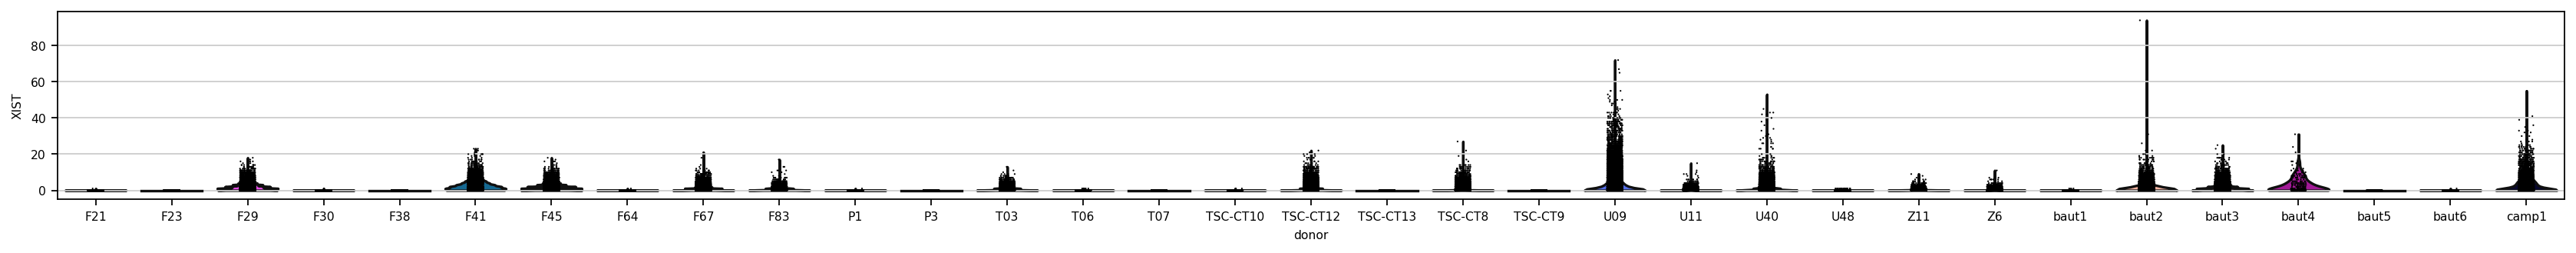

In [59]:
sc.set_figure_params(figsize=[20,2],fontsize=7)
sc.pl.violin(adata_full,keys=['XIST'],groupby='donor')

In [4]:
h5ad_file = ''

adata_full = sc.read_h5ad(h5ad_file)
# adata_full.write_h5ad(h5ad_file)


In [7]:
import pandas as pd

mapping_dict = {
    'T_ISP':'T_ETP',
    'T_DN(early)': 'T_DN(early)',
    'T_DN(P)':'T_DN(P)',
    'T_DN(Q)-early': 'T_DN(Q)-intermediate',
    'T_DN(Q)':'T_DN(Q)',
    'T_DN(Q)-CD99':'T_DN(Q)-stress_1',
    'T_DN(Q)-HSPH1': 'T_DN(Q)-stress_2',
    'T_reg(agonist)':'T_Treg(agonist)',         
    'T_reg(diff)-FOXP3hi':'T_Treg-diff_2',
    'T_Treg_recirc':'T_Treg_recirc',          
    'T_reg(diff)-FOXP3Lo':'T_Treg-diff_1',  
    'T_Treg_mature':'T_Treg_mature' ,
    'T_Treg_CD8':'T_Treg_CD8',              
    'T_reg':'T_Treg-intermediate',     
    'T_abT(entry)':'T_αβT(entry)'
}

anno_column = 'cell_type_level_4'

adata_full.obs[anno_column] = adata_full.obs[anno_column].astype('object')

for original, new in mapping_dict.items():
    print(f'changed: {original} to: {new}')
    adata_full.obs.loc[adata_full.obs[anno_column] == original, anno_column] = new

adata_full.obs[anno_column] = adata_full.obs[anno_column].astype('category')

original_categories = adata_full.obs[anno_column].cat.categories
new_categories = [mapping_dict[cat] if cat in mapping_dict else cat for cat in original_categories]

for cat in mapping_dict.values():
    if cat not in new_categories:
        new_categories.append(cat)

adata_full.obs[anno_column] = pd.Categorical(adata_full.obs[anno_column], categories=new_categories)
adata_full.obs[anno_column] = adata_full.obs[anno_column].cat.reorder_categories(new_categories)

changed: T_ISP to: T_ETP
changed: T_DN(early) to: T_DN(early)
changed: T_DN(P) to: T_DN(P)
changed: T_DN(Q)-early to: T_DN(Q)-intermediate
changed: T_DN(Q) to: T_DN(Q)
changed: T_DN(Q)-CD99 to: T_DN(Q)-stress_1
changed: T_DN(Q)-HSPH1 to: T_DN(Q)-stress_2
changed: T_reg(agonist) to: T_Treg(agonist)
changed: T_reg(diff)-FOXP3hi to: T_Treg-diff_2
changed: T_Treg_recirc to: T_Treg_recirc
changed: T_reg(diff)-FOXP3Lo to: T_Treg-diff_1
changed: T_Treg_mature to: T_Treg_mature
changed: T_Treg_CD8 to: T_Treg_CD8
changed: T_reg to: T_Treg-intermediate
changed: T_abT(entry) to: T_αβT(entry)


In [8]:
adata_full.write_h5ad(h5ad_file)

In [61]:
adata_post_QC = adata_full[adata_full.obs['cell_type_level_0']!='FailQC']
adata_post_QC

View of AnnData object with n_obs × n_vars = 498018 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_cou

In [63]:
h5ad_file = ''
# adata_full = sc.read_h5ad(h5ad_file)
adata_post_QC.write_h5ad(h5ad_file)

In [4]:
h5ad_file = ''
adata_post_QC = sc.read_h5ad(h5ad_file)
# adata_post_QC.write_h5ad(h5ad_file)

In [6]:
import pandas as pd

mapping_dict = {
    'T_ISP':'T_ETP',
    'T_DN(early)': 'T_DN(early)',
    'T_DN(P)':'T_DN(P)',
    'T_DN(Q)-early': 'T_DN(Q)-intermediate',
    'T_DN(Q)':'T_DN(Q)',
    'T_DN(Q)-CD99':'T_DN(Q)-stress_1',
    'T_DN(Q)-HSPH1': 'T_DN(Q)-stress_2',
    'T_reg(agonist)':'T_Treg(agonist)',         
    'T_reg(diff)-FOXP3hi':'T_Treg-diff_2',
    'T_Treg_recirc':'T_Treg_recirc',          
    'T_reg(diff)-FOXP3Lo':'T_Treg-diff_1',  
    'T_Treg_mature':'T_Treg_mature' ,
    'T_Treg_CD8':'T_Treg_CD8',              
    'T_reg':'T_Treg-intermediate',     
    'T_abT(entry)':'T_αβT(entry)'
}

anno_column = 'cell_type_level_4'

adata_post_QC.obs[anno_column] = adata_post_QC.obs[anno_column].astype('object')

for original, new in mapping_dict.items():
    print(f'changed: {original} to: {new}')
    adata_post_QC.obs.loc[adata_post_QC.obs[anno_column] == original, anno_column] = new

adata_post_QC.obs[anno_column] = adata_post_QC.obs[anno_column].astype('category')

original_categories = adata_post_QC.obs[anno_column].cat.categories
new_categories = [mapping_dict[cat] if cat in mapping_dict else cat for cat in original_categories]

for cat in mapping_dict.values():
    if cat not in new_categories:
        new_categories.append(cat)

adata_post_QC.obs[anno_column] = pd.Categorical(adata_post_QC.obs[anno_column], categories=new_categories)
adata_post_QC.obs[anno_column] = adata_post_QC.obs[anno_column].cat.reorder_categories(new_categories)

In [6]:
adata_post_QC.write_h5ad('')

changed: T_abT(entry) to: T_αβT(entry)
